# Promoter CNN with One-Hot Encoding

This notebook implements a comprehensive Promoter CNN model using one-hot encoding for DNA sequences. It leverages the modular codebase structure to ensure consistency and reproducibility.

## Features
- **One-hot encoding** of DNA sequences (A, T, G, C, N)
- **Optimized CNN architecture** with configurable depth and channels
- **Hyperparameter management** using best configurations
- **Device-agnostic training** (CUDA/MPS/CPU)
- **Comprehensive evaluation** and visualization
- **Modular design** for easy experimentation

## Table of Contents
1. [Environment Setup](#Environment-Setup)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
3. [Model Architecture](#Model-Architecture)
4. [Training Configuration](#Training-Configuration)
5. [Training Loop](#Training-Loop)
6. [Evaluation and Results](#Evaluation-and-Results)
7. [Visualization](#Visualization)
8. [Model Saving](#Model-Saving)


## Environment Setup

First, let's import all necessary libraries and modules from our codebase.


In [41]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam, AdamW, SGD, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, ExponentialLR

# Sklearn for metrics
from sklearn.metrics import r2_score, mean_squared_error

# Add project root to path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

print(f"Project root: {project_root}")
print(f"Python path updated")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if hasattr(torch.backends, 'mps'):
    print(f"MPS available: {torch.backends.mps.is_available()}")
else:
    print("MPS not available")


Project root: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression
Python path updated
PyTorch version: 2.5.1
CUDA available: False
MPS available: True


In [42]:
# Import custom modules from our codebase
try:
    # Core model and data utilities
    from src.models.cnn.model import PromoterCNN
    from src.utils.data import PromoterDataset, load_and_prepare_data
    
    # Training and evaluation utilities
    from src.utils.training import train_epoch, validate_epoch, evaluate_model
    from src.utils.device import create_device_manager
    
    # Visualization utilities
    from src.utils.viz import plot_results
    
    # Hyperparameter management
    from src.hyperparameter_tuning.config import load_best_config, HyperparameterConfig
    from src.hyperparameter_tuning.search_spaces import SearchSpaceType, get_search_space
    
    print("✅ Successfully imported all custom modules")
    print("   📁 CNN Model: PromoterCNN")
    print("   📁 Data Utils: PromoterDataset, load_and_prepare_data")
    print("   📁 Training Utils: train_epoch, validate_epoch, evaluate_model")
    print("   📁 Device Utils: create_device_manager")
    print("   📁 Visualization: plot_results")
    print("   📁 Hyperparameters: load_best_config, HyperparameterConfig")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure the project structure is correct and src/ modules are available")


✅ Successfully imported all custom modules
   📁 CNN Model: PromoterCNN
   📁 Data Utils: PromoterDataset, load_and_prepare_data
   📁 Training Utils: train_epoch, validate_epoch, evaluate_model
   📁 Device Utils: create_device_manager
   📁 Visualization: plot_results
   📁 Hyperparameters: load_best_config, HyperparameterConfig


## Configuration and Device Setup

Let's configure the experiment parameters and set up device management.


In [43]:
# Experiment configuration
EXPERIMENT_NAME = "promoter_cnn_onehot"
SEQUENCE_LENGTH = 600
RANDOM_SEED = 42

# Data paths
DATA_PATH = project_root / "data" / "processed" / "ProSeq_with_5component_analysis.csv"
OUTPUT_DIR = project_root / "results"
MODEL_WEIGHTS_DIR = OUTPUT_DIR / "model_weights"
PLOTS_DIR = OUTPUT_DIR / "plots"

# Create output directories
MODEL_WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"🔧 Experiment Configuration:")
print(f"   Name: {EXPERIMENT_NAME}")
print(f"   Sequence Length: {SEQUENCE_LENGTH}")
print(f"   Random Seed: {RANDOM_SEED}")
print(f"   Data Path: {DATA_PATH}")
print(f"   Output Directory: {OUTPUT_DIR}")
print(f"   Model Weights: {MODEL_WEIGHTS_DIR}")
print(f"   Plots: {PLOTS_DIR}")


🔧 Experiment Configuration:
   Name: promoter_cnn_onehot
   Sequence Length: 600
   Random Seed: 42
   Data Path: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/data/processed/ProSeq_with_5component_analysis.csv
   Output Directory: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results
   Model Weights: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/model_weights
   Plots: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/plots


In [44]:
# Device setup using our custom device manager
print("🖥️  Setting up device management...")
device_manager = create_device_manager(prefer_cuda=True, verbose=True)

# Get device information
device = device_manager.device
device_name = device_manager.device_name
loader_kwargs = device_manager.get_dataloader_kwargs()

print(f"\n📱 Device Configuration:")
print(f"   Device: {device}")
print(f"   Device Name: {device_name}")
print(f"   DataLoader kwargs: {loader_kwargs}")

# Display memory info if available
memory_info = device_manager.get_memory_info()
if memory_info['total'] > 0:
    print(f"   Memory Total: {memory_info['total']:.1f} GB")
    print(f"   Memory Free: {memory_info['free']:.1f} GB")


🖥️  Setting up device management...

📱 Device Configuration:
   Device: mps
   Device Name: mps
   DataLoader kwargs: {'num_workers': 0}


## Data Loading and Preprocessing

Load the promoter sequence data and create datasets with automatic one-hot encoding.


In [45]:
# Load data using our custom data loading function
print("📊 Loading promoter sequence data...")
print(f"   Data path: {DATA_PATH}")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

sequences, targets = load_and_prepare_data(str(DATA_PATH))

print(f"\n📈 Data Overview:")
print(f"   Total sequences: {len(sequences)}")
print(f"   Target shape: {targets.shape}")
print(f"   Sequence length range: {min(len(seq) for seq in sequences)} - {max(len(seq) for seq in sequences)}")

# Display data statistics
print(f"\n📊 Target Statistics:")
print(f"   Component 1: mean={targets[:, 0].mean():.3f}, std={targets[:, 0].std():.3f}")
print(f"   Component 2: mean={targets[:, 1].mean():.3f}, std={targets[:, 1].std():.3f}")
print(f"   Component 3: mean={targets[:, 2].mean():.3f}, std={targets[:, 2].std():.3f}")
print(f"   Component 4: mean={targets[:, 3].mean():.3f}, std={targets[:, 3].std():.3f}")
print(f"   Component 5: mean={targets[:, 4].mean():.3f}, std={targets[:, 4].std():.3f}")

# Show example sequence
print(f"\n🧬 Example DNA Sequence (first 100 bp):")
print(f"   {sequences[0][:100]}...")
print(f"   Length: {len(sequences[0])} bp")
print(f"   Targets: {targets[0]}")


📊 Loading promoter sequence data...
   Data path: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/data/processed/ProSeq_with_5component_analysis.csv

📈 Data Overview:
   Total sequences: 8304
   Target shape: (8304, 5)
   Sequence length range: 472 - 600

📊 Target Statistics:
   Component 1: mean=0.088, std=0.250
   Component 2: mean=0.320, std=0.376
   Component 3: mean=0.115, std=0.274
   Component 4: mean=0.214, std=0.313
   Component 5: mean=0.264, std=0.381

🧬 Example DNA Sequence (first 100 bp):
   AAGCTGCACAGTCGAGCCTGCGGCTCCGCAGCCGAATAGAGCGGAAATGCCCTCTCAGGGCATCAAAGAGCAACAAGCTGCCACTGTAAGAGGGGCCCAG...
   Length: 600 bp
   Targets: [6.32430892e-10 1.75677897e-04 2.10593641e-01 4.88930448e-07
 7.89230191e-01]


In [46]:
# Demonstrate one-hot encoding
print("🔢 One-Hot Encoding Demonstration:")
print("   DNA bases: A=0, T=1, G=2, C=3, N=4")

# Create a sample dataset to show encoding
sample_dataset = PromoterDataset([sequences[0]], targets[:1], max_length=SEQUENCE_LENGTH)
sample_batch = sample_dataset[0]

encoded_sequence = sample_batch["sequence"]
target_probs = sample_batch["target"]

print(f"\n📏 Encoded Sequence Shape: {encoded_sequence.shape}")
print(f"   Expected: (5, {SEQUENCE_LENGTH}) for Conv1d input")
print(f"   Actual: {tuple(encoded_sequence.shape)}")

print(f"\n🎯 Target Shape: {target_probs.shape}")
print(f"   Target values: {target_probs.numpy()}")
print(f"   Target sum: {target_probs.sum():.6f} (should be ~1.0 for normalized probabilities)")

# Show first 20 positions of encoding for visualization
print(f"\n🧬 First 20 positions one-hot encoding:")
first_20 = encoded_sequence[:, :20].numpy()
bases = ['A', 'T', 'G', 'C', 'N']
for i, base in enumerate(bases):
    positions = np.where(first_20[i] == 1)[0]
    print(f"   {base}: positions {list(positions)}")

# Verify encoding correctness
original_seq = sequences[0][:20]
print(f"\n✅ Verification (first 20 bp):")
print(f"   Original: {original_seq}")
reconstructed = ""
for pos in range(20):
    base_idx = np.argmax(first_20[:, pos])
    reconstructed += ['A', 'T', 'G', 'C', 'N'][base_idx]
print(f"   Reconstructed: {reconstructed}")
print(f"   Match: {original_seq.upper() == reconstructed}")


🔢 One-Hot Encoding Demonstration:
   DNA bases: A=0, T=1, G=2, C=3, N=4

📏 Encoded Sequence Shape: torch.Size([5, 600])
   Expected: (5, 600) for Conv1d input
   Actual: (5, 600)

🎯 Target Shape: torch.Size([5])
   Target values: [6.3243089e-10 1.7567789e-04 2.1059364e-01 4.8893043e-07 7.8923017e-01]
   Target sum: 1.000000 (should be ~1.0 for normalized probabilities)

🧬 First 20 positions one-hot encoding:
   A: positions [np.int64(0), np.int64(1), np.int64(7), np.int64(9), np.int64(14)]
   T: positions [np.int64(4), np.int64(11), np.int64(18)]
   G: positions [np.int64(2), np.int64(5), np.int64(10), np.int64(13), np.int64(15), np.int64(19)]
   C: positions [np.int64(3), np.int64(6), np.int64(8), np.int64(12), np.int64(16), np.int64(17)]
   N: positions []

✅ Verification (first 20 bp):
   Original: AAGCTGCACAGTCGAGCCTG
   Reconstructed: AAGCTGCACAGTCGAGCCTG
   Match: True


In [47]:
# Create train/validation/test splits
print("🔀 Creating train/validation/test splits...")

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
total_size = len(sequences)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"   Total samples: {total_size}")
print(f"   Train: {train_size} ({train_ratio:.1%})")
print(f"   Validation: {val_size} ({val_ratio:.1%})")
print(f"   Test: {test_size} ({test_ratio:.1%})")

# Create full dataset first
full_dataset = PromoterDataset(sequences, targets, max_length=SEQUENCE_LENGTH)

# Split the dataset
train_dataset, temp_dataset = random_split(
    full_dataset, 
    [train_size, val_size + test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

val_dataset, test_dataset = random_split(
    temp_dataset, 
    [val_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

print(f"\n✅ Dataset splits created:")
print(f"   Train dataset: {len(train_dataset)} samples")
print(f"   Validation dataset: {len(val_dataset)} samples")
print(f"   Test dataset: {len(test_dataset)} samples")


🔀 Creating train/validation/test splits...
   Total samples: 8304
   Train: 5812 (70.0%)
   Validation: 1245 (15.0%)
   Test: 1247 (15.0%)

✅ Dataset splits created:
   Train dataset: 5812 samples
   Validation dataset: 1245 samples
   Test dataset: 1247 samples


## Model Architecture and Hyperparameters

Load the best hyperparameters and create the CNN model with optimized architecture.


In [54]:
# Load best hyperparameters
print("⚙️  Loading optimized hyperparameters...")
try:
    config = load_best_config('promoter_cnn')
    print("✅ Loaded best hyperparameter configuration")
except Exception as e:
    print(f"⚠️  Could not load best config: {e}")
    print("   Using default configuration")
    config = HyperparameterConfig(model_name='promoter_cnn')

print(f"\n🏗️  Model Architecture Configuration:")
print(f"   Depth (conv blocks): {config.depth}")
print(f"   Base channels: {config.base_channels}")
print(f"   Dropout: {config.dropout}")
print(f"   Sequence length: {SEQUENCE_LENGTH}")
print(f"   Number of classes: {config.num_classes}")

print(f"\n🎓 Training Configuration:")
print(f"   Optimizer: {config.optimizer}")
print(f"   Learning rate: {config.learning_rate}")
print(f"   Weight decay: {config.weight_decay}")
print(f"   Batch size: {config.batch_size}")
print(f"   Number of epochs: {config.num_epochs}")
print(f"   Early stopping patience: {config.early_stopping_patience}")
print(f"   Loss function: {config.loss_function}")

print(f"\n📊 Scheduler Configuration:")
print(f"   Scheduler: {config.scheduler}")
print(f"   Patience: {config.scheduler_patience}")
print(f"   Factor: {config.scheduler_factor}")

# Create model using best configuration
print(f"\n🚀 Creating PromoterCNN model...")
model = PromoterCNN(sequence_length=SEQUENCE_LENGTH, num_blocks=config.depth, base_channels=config.base_channels, dropout=config.dropout, num_classes=config.num_classes)

# Move model to device
model = device_manager.create_model_wrapper(model)

# Display model summary
print(f"\n📋 Model Summary:")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   Model device: {next(model.parameters()).device}")

# Print model architecture
print(f"\n🏗️  Model Architecture:")
print(model)


⚙️  Loading optimized hyperparameters...
✅ Loaded best hyperparameter configuration

🏗️  Model Architecture Configuration:
   Depth (conv blocks): 2
   Base channels: 24
   Dropout: 0.2
   Sequence length: 600
   Number of classes: 5

🎓 Training Configuration:
   Optimizer: adam
   Learning rate: 0.01
   Weight decay: 1e-05
   Batch size: 128
   Number of epochs: 50
   Early stopping patience: 10
   Loss function: kldiv

📊 Scheduler Configuration:
   Scheduler: plateau
   Patience: 8
   Factor: 0.3

🚀 Creating PromoterCNN model...

📋 Model Summary:
   Total parameters: 5,525
   Trainable parameters: 5,525
   Model device: mps:0

🏗️  Model Architecture:
PromoterCNN(
  (sequence_conv): Sequential(
    (0): Conv1d(5, 24, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(24, 24, kernel_size=(7,), stride=(1,), padding=(3,))
    (5): ReLU()
  

In [55]:
# Create data loaders with device-optimized settings
print("🔄 Creating data loaders...")

dataloader_kwargs = device_manager.get_dataloader_kwargs(
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True
)

train_loader = DataLoader(train_dataset, **dataloader_kwargs)

# Validation and test loaders don't need shuffling
val_kwargs = dataloader_kwargs.copy()
val_kwargs['shuffle'] = False
val_loader = DataLoader(val_dataset, **val_kwargs)
test_loader = DataLoader(test_dataset, **val_kwargs)

print(f"✅ Data loaders created:")
print(f"   Train loader: {len(train_loader)} batches")
print(f"   Validation loader: {len(val_loader)} batches")
print(f"   Test loader: {len(test_loader)} batches")
print(f"   Batch size: {config.batch_size}")
print(f"   DataLoader kwargs: {dataloader_kwargs}")

# Test a batch to ensure everything works
print(f"\n🧪 Testing data loading...")
sample_batch = next(iter(train_loader))
sample_sequences = sample_batch["sequence"]
sample_targets = sample_batch["target"]

print(f"   Batch sequences shape: {sample_sequences.shape}")
print(f"   Batch targets shape: {sample_targets.shape}")
print(f"   Sequences device: {sample_sequences.device}")
print(f"   Targets device: {sample_targets.device}")

# Test model forward pass
with torch.no_grad():
    sample_sequences = device_manager.to_device(sample_sequences)
    sample_output = model(sample_sequences)
    print(f"   Model output shape: {sample_output.shape}")
    print(f"   Output device: {sample_output.device}")

print("✅ Data loading and model forward pass successful!")


🔄 Creating data loaders...
✅ Data loaders created:
   Train loader: 45 batches
   Validation loader: 9 batches
   Test loader: 9 batches
   Batch size: 128
   DataLoader kwargs: {'num_workers': 0, 'batch_size': 128, 'shuffle': True, 'drop_last': True}

🧪 Testing data loading...
   Batch sequences shape: torch.Size([128, 5, 600])
   Batch targets shape: torch.Size([128, 5])
   Sequences device: cpu
   Targets device: cpu
   Model output shape: torch.Size([128, 5])
   Output device: mps:0
✅ Data loading and model forward pass successful!


## Training Configuration

Set up optimizer, loss function, and scheduler based on the best hyperparameters.


In [50]:
# Set up optimizer based on configuration
print(f"🎯 Setting up optimizer: {config.optimizer}")

optimizer_params = config.get_optimizer_params()
print(f"   Optimizer parameters: {optimizer_params}")

if config.optimizer.lower() == 'adam':
    optimizer = Adam(model.parameters(), **optimizer_params)
elif config.optimizer.lower() == 'adamw':
    optimizer = AdamW(model.parameters(), **optimizer_params)
elif config.optimizer.lower() == 'sgd':
    optimizer = SGD(model.parameters(), **optimizer_params)
elif config.optimizer.lower() == 'rmsprop':
    optimizer = RMSprop(model.parameters(), **optimizer_params)
else:
    print(f"⚠️  Unknown optimizer {config.optimizer}, using Adam")
    optimizer = Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

print(f"✅ Optimizer created: {type(optimizer).__name__}")

# Set up loss function
print(f"\n🎯 Setting up loss function: {config.loss_function}")

if config.loss_function.lower() == 'kldiv':
    criterion = nn.KLDivLoss(reduction='batchmean')
elif config.loss_function.lower() == 'mse':
    criterion = nn.MSELoss()
elif config.loss_function.lower() == 'crossentropy':
    criterion = nn.CrossEntropyLoss()
else:
    print(f"⚠️  Unknown loss function {config.loss_function}, using KLDivLoss")
    criterion = nn.KLDivLoss(reduction='batchmean')

print(f"✅ Loss function created: {type(criterion).__name__}")

# Set up learning rate scheduler
print(f"\n📊 Setting up scheduler: {config.scheduler}")

scheduler_params = config.get_scheduler_params()
print(f"   Scheduler parameters: {scheduler_params}")

if config.scheduler.lower() == 'plateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', **scheduler_params)
elif config.scheduler.lower() == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, **scheduler_params)
elif config.scheduler.lower() == 'step':
    scheduler = StepLR(optimizer, **scheduler_params)
elif config.scheduler.lower() == 'exponential':
    scheduler = ExponentialLR(optimizer, **scheduler_params)
elif config.scheduler.lower() == 'none':
    scheduler = None
    print("   No scheduler selected")
else:
    print(f"⚠️  Unknown scheduler {config.scheduler}, using ReduceLROnPlateau")
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

if scheduler:
    print(f"✅ Scheduler created: {type(scheduler).__name__}")

print(f"\n🚀 Training setup complete!")
print(f"   Model: {type(model).__name__}")
print(f"   Optimizer: {type(optimizer).__name__}")
print(f"   Loss function: {type(criterion).__name__}")
print(f"   Scheduler: {type(scheduler).__name__ if scheduler else 'None'}")
print(f"   Device: {device}")


🎯 Setting up optimizer: adam
   Optimizer parameters: {'lr': 0.01, 'weight_decay': 1e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'amsgrad': False}
✅ Optimizer created: Adam

🎯 Setting up loss function: kldiv
✅ Loss function created: KLDivLoss

📊 Setting up scheduler: plateau
   Scheduler parameters: {'patience': 8, 'factor': 0.3}
✅ Scheduler created: ReduceLROnPlateau

🚀 Training setup complete!
   Model: PromoterCNN
   Optimizer: Adam
   Loss function: KLDivLoss
   Scheduler: ReduceLROnPlateau
   Device: mps


## Training Loop

Train the model using our standardized training functions with early stopping and progress tracking.


In [51]:
# Training setup
print("🚂 Starting training...")
start_time = time.time()

# Initialize tracking variables
train_losses = []
val_losses = []
learning_rates = []
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"📊 Training Configuration:")
print(f"   Epochs: {config.num_epochs}")
print(f"   Early stopping patience: {config.early_stopping_patience}")
print(f"   Batch size: {config.batch_size}")
print(f"   Learning rate: {config.learning_rate}")

# Training loop
for epoch in range(config.num_epochs):
    epoch_start_time = time.time()
    
    # Training phase
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    if scheduler:
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(current_lr)
    
    # Early stopping and best model tracking
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        improvement_marker = "🔥"
    else:
        patience_counter += 1
        improvement_marker = "  "
    
    epoch_time = time.time() - epoch_start_time
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{config.num_epochs} {improvement_marker} │ "
          f"Train Loss: {train_loss:.6f} │ "
          f"Val Loss: {val_loss:.6f} │ "
          f"LR: {current_lr:.2e} │ "
          f"Time: {epoch_time:.1f}s │ "
          f"Patience: {patience_counter}/{config.early_stopping_patience}")
    
    # Early stopping check
    if patience_counter >= config.early_stopping_patience:
        print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
        print(f"   Best validation loss: {best_val_loss:.6f}")
        break
    
    # Memory cleanup
    if device_name == "cuda":
        device_manager.empty_cache()

# Load best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model with validation loss: {best_val_loss:.6f}")

total_time = time.time() - start_time
print(f"\n🏁 Training completed!")
print(f"   Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Best validation loss: {best_val_loss:.6f}")
print(f"   Final learning rate: {learning_rates[-1]:.2e}")


🚂 Starting training...
📊 Training Configuration:
   Epochs: 50
   Early stopping patience: 10
   Batch size: 128
   Learning rate: 0.01
Epoch   1/50 🔥 │ Train Loss: 1.121480 │ Val Loss: 1.123592 │ LR: 1.00e-02 │ Time: 1.1s │ Patience: 0/10
Epoch   2/50 🔥 │ Train Loss: 1.116665 │ Val Loss: 1.122338 │ LR: 1.00e-02 │ Time: 0.9s │ Patience: 0/10
Epoch   3/50    │ Train Loss: 1.113767 │ Val Loss: 1.122925 │ LR: 1.00e-02 │ Time: 0.9s │ Patience: 1/10
Epoch   4/50    │ Train Loss: 1.116466 │ Val Loss: 1.122343 │ LR: 1.00e-02 │ Time: 0.9s │ Patience: 2/10
Epoch   5/50    │ Train Loss: 1.112131 │ Val Loss: 1.125903 │ LR: 1.00e-02 │ Time: 0.9s │ Patience: 3/10
Epoch   6/50 🔥 │ Train Loss: 1.113761 │ Val Loss: 1.121171 │ LR: 1.00e-02 │ Time: 0.9s │ Patience: 0/10
Epoch   7/50    │ Train Loss: 1.113377 │ Val Loss: 1.121951 │ LR: 1.00e-02 │ Time: 1.0s │ Patience: 1/10
Epoch   8/50    │ Train Loss: 1.109908 │ Val Loss: 1.125226 │ LR: 1.00e-02 │ Time: 0.9s │ Patience: 2/10
Epoch   9/50    │ Train Los

## Model Evaluation

Evaluate the trained model on the test set and compute comprehensive metrics.


In [52]:
# Evaluate model on test set
print("📊 Evaluating model on test set...")

predictions, targets_eval = evaluate_model(model, test_loader, device)

print(f"✅ Evaluation completed:")
print(f"   Predictions shape: {predictions.shape}")
print(f"   Targets shape: {targets_eval.shape}")
print(f"   Test samples: {len(test_dataset)}")

# Calculate comprehensive metrics
print(f"\n📈 Computing metrics for each component...")

metrics = {}
component_names = [f"Component_{i+1}" for i in range(5)]

for i, component in enumerate(component_names):
    pred_i = predictions[:, i]
    target_i = targets_eval[:, i]
    
    # Calculate metrics
    r2 = r2_score(target_i, pred_i)
    mse = mean_squared_error(target_i, pred_i)
    mae = np.mean(np.abs(target_i - pred_i))
    pearson_corr = np.corrcoef(target_i, pred_i)[0, 1]
    
    metrics[component] = {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'Pearson': pearson_corr
    }
    
    print(f"   {component}:")
    print(f"      R² Score: {r2:.4f}")
    print(f"      MSE: {mse:.6f}")
    print(f"      MAE: {mae:.6f}")
    print(f"      Pearson: {pearson_corr:.4f}")

# Overall metrics
overall_r2 = np.mean([metrics[comp]['R2'] for comp in component_names])
overall_mse = np.mean([metrics[comp]['MSE'] for comp in component_names])
overall_mae = np.mean([metrics[comp]['MAE'] for comp in component_names])
overall_pearson = np.mean([metrics[comp]['Pearson'] for comp in component_names])

print(f"\n🎯 Overall Performance:")
print(f"   Average R² Score: {overall_r2:.4f}")
print(f"   Average MSE: {overall_mse:.6f}")
print(f"   Average MAE: {overall_mae:.6f}")
print(f"   Average Pearson: {overall_pearson:.4f}")

# Additional analysis
print(f"\n🔍 Additional Analysis:")
pred_sums = predictions.sum(axis=1)
target_sums = targets_eval.sum(axis=1)
print(f"   Prediction sums - Mean: {pred_sums.mean():.4f}, Std: {pred_sums.std():.4f}")
print(f"   Target sums - Mean: {target_sums.mean():.4f}, Std: {target_sums.std():.4f}")
print(f"   Sum difference MSE: {mean_squared_error(target_sums, pred_sums):.6f}")

# Best and worst performing components
best_component = max(component_names, key=lambda x: metrics[x]['R2'])
worst_component = min(component_names, key=lambda x: metrics[x]['R2'])
print(f"   Best performing component: {best_component} (R² = {metrics[best_component]['R2']:.4f})")
print(f"   Worst performing component: {worst_component} (R² = {metrics[worst_component]['R2']:.4f})")


📊 Evaluating model on test set...
✅ Evaluation completed:
   Predictions shape: (1152, 5)
   Targets shape: (1152, 5)
   Test samples: 1247

📈 Computing metrics for each component...
   Component_1:
      R² Score: 0.0050
      MSE: 0.058984
      MAE: 0.137970
      Pearson: 0.0797
   Component_2:
      R² Score: 0.0052
      MSE: 0.145680
      MAE: 0.347728
      Pearson: 0.0868
   Component_3:
      R² Score: -0.0065
      MSE: 0.068032
      MAE: 0.171495
      Pearson: -0.0053
   Component_4:
      R² Score: 0.0037
      MSE: 0.097543
      MAE: 0.257648
      Pearson: 0.0723
   Component_5:
      R² Score: -0.0009
      MSE: 0.141700
      MAE: 0.333733
      Pearson: 0.0282

🎯 Overall Performance:
   Average R² Score: 0.0013
   Average MSE: 0.102388
   Average MAE: 0.249715
   Average Pearson: 0.0523

🔍 Additional Analysis:
   Prediction sums - Mean: 1.0000, Std: 0.0000
   Target sums - Mean: 1.0000, Std: 0.0000
   Sum difference MSE: 0.000000
   Best performing component: Comp

## Visualization

Generate comprehensive plots using our visualization utilities.


📊 Generating visualizations...


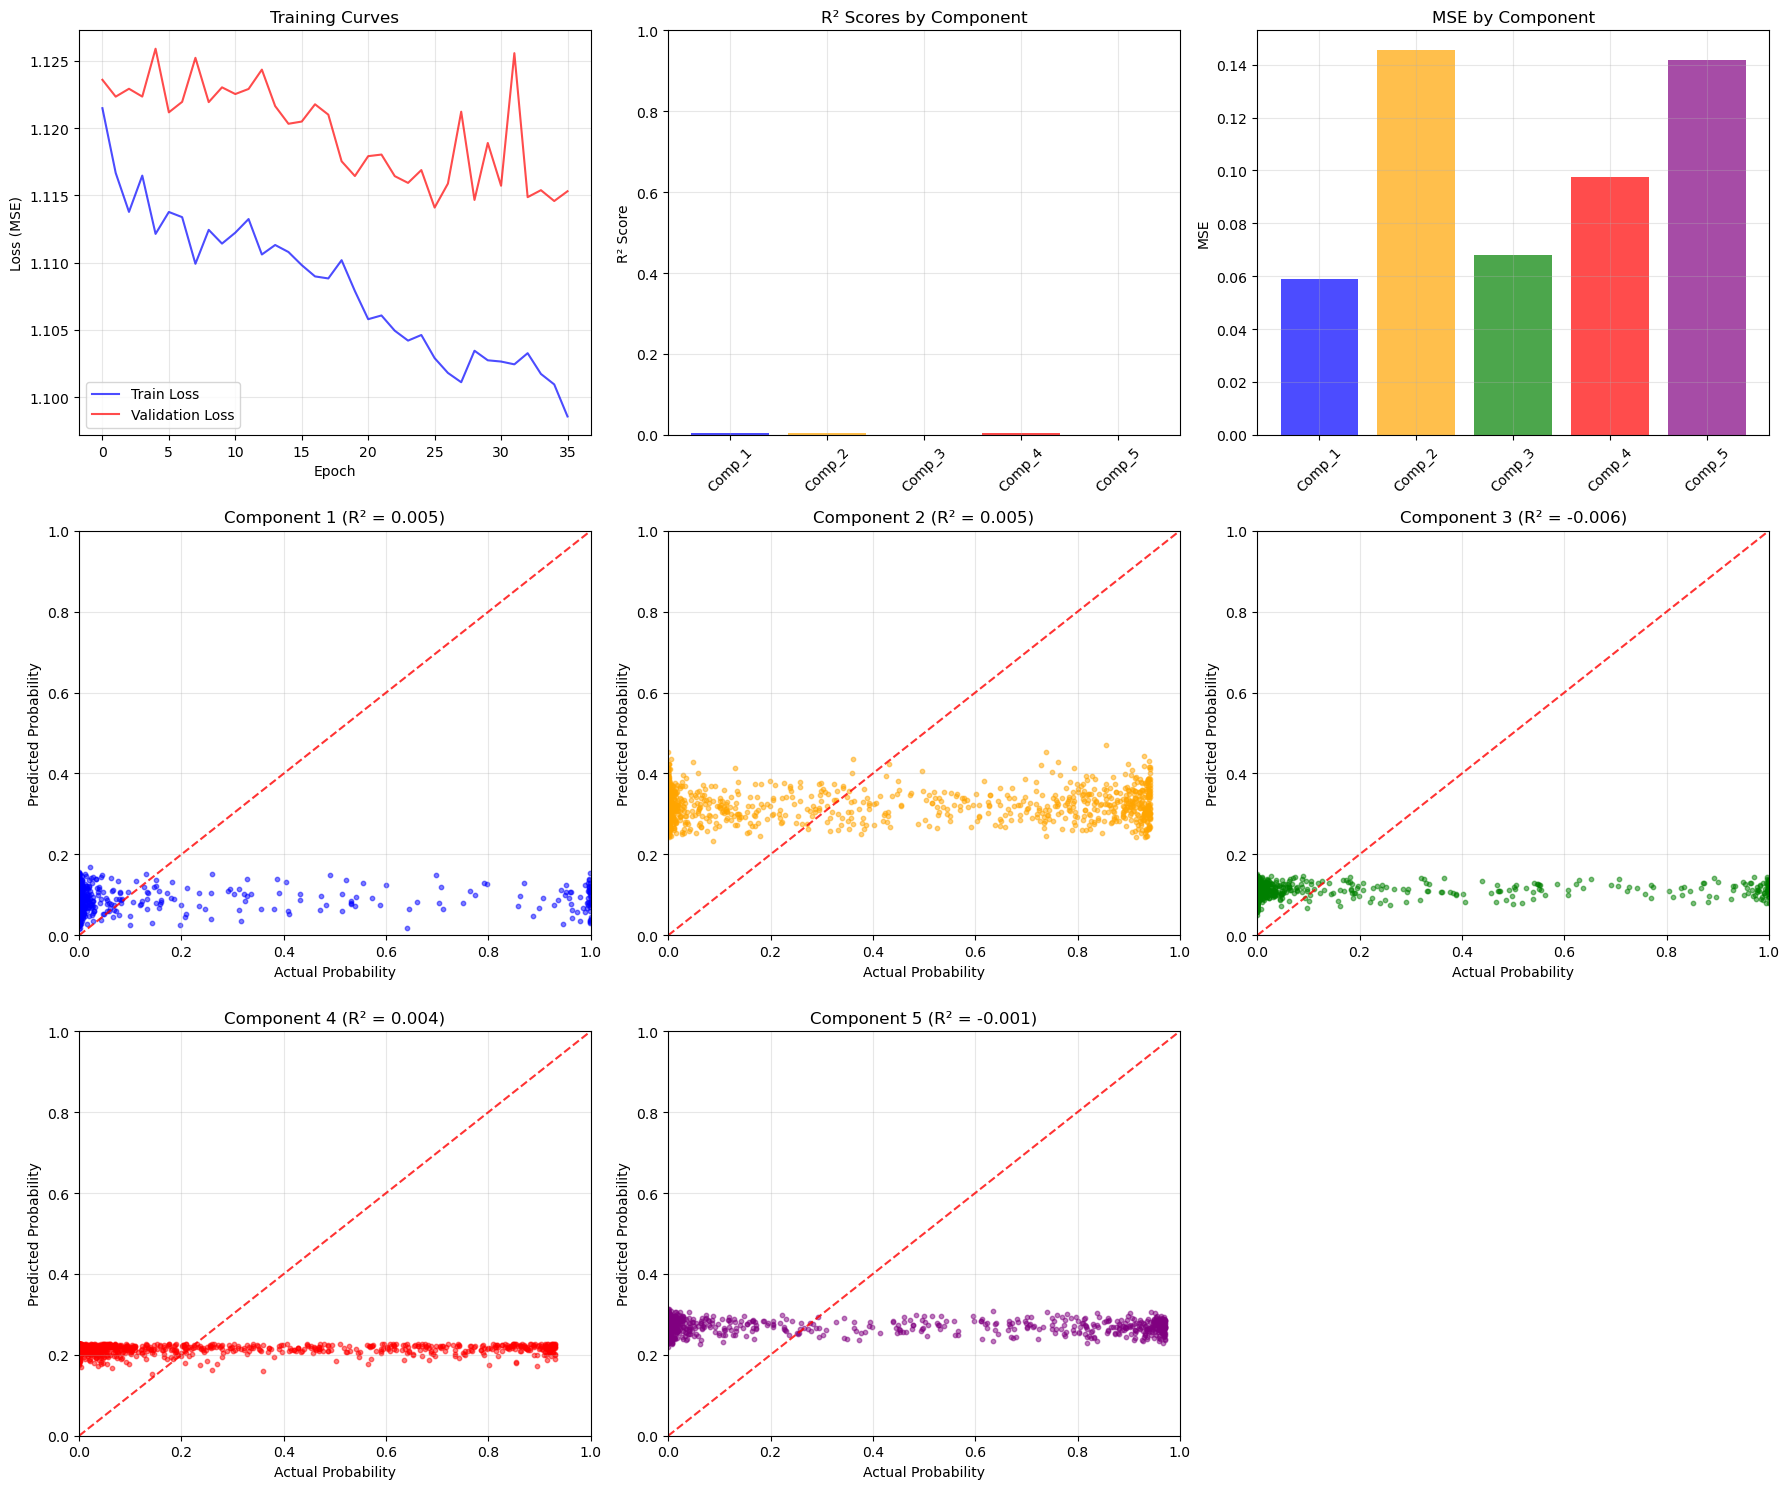

✅ Plots saved to: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/plots/promoter_cnn_onehot_results.png


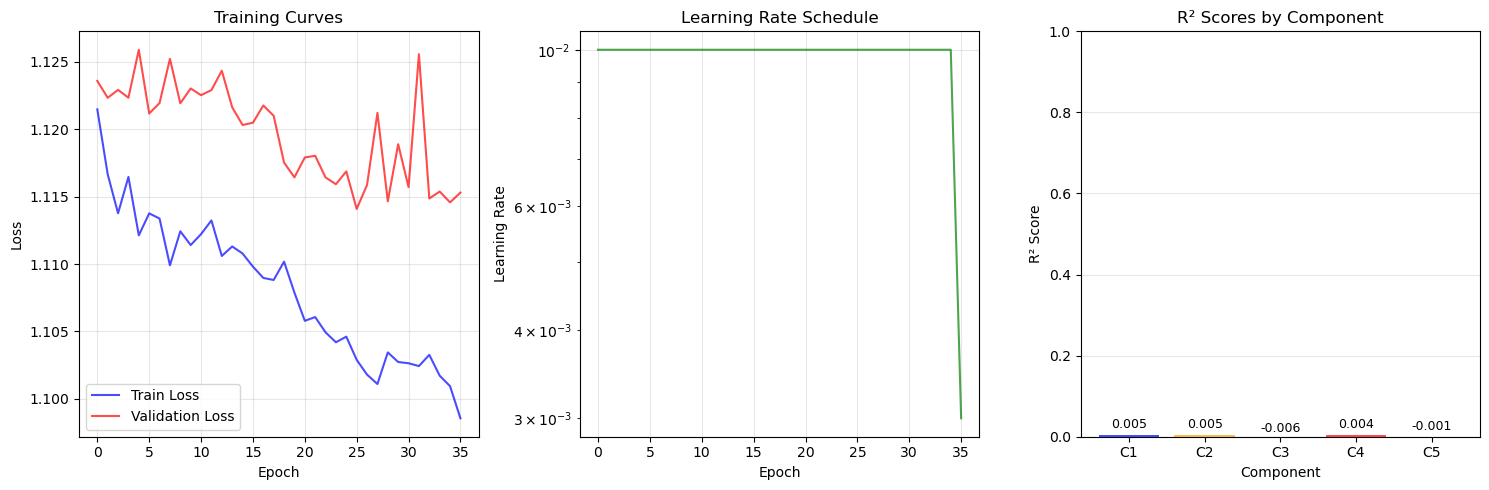

✅ Additional plots saved to: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression/results/plots/promoter_cnn_onehot_training_summary.png


In [53]:
# Generate comprehensive plots using our visualization function
print("📊 Generating visualizations...")

plot_path = PLOTS_DIR / f"{EXPERIMENT_NAME}_results.png"

# Use our custom plotting function
plot_results(
    train_losses=train_losses,
    val_losses=val_losses,
    metrics=metrics,
    predictions=predictions,
    targets=targets_eval,
    out_path=str(plot_path)
)

print(f"✅ Plots saved to: {plot_path}")

# Additional training curves plot
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate schedule
plt.subplot(1, 3, 2)
plt.plot(learning_rates, color='green', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# R² scores by component
plt.subplot(1, 3, 3)
r2_scores = [metrics[comp]['R2'] for comp in component_names]
colors = ['blue', 'orange', 'green', 'red', 'purple']
bars = plt.bar(range(5), r2_scores, color=colors, alpha=0.7)
plt.xlabel('Component')
plt.ylabel('R² Score')
plt.title('R² Scores by Component')
plt.xticks(range(5), [f'C{i+1}' for i in range(5)])
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{r2_scores[i]:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / f"{EXPERIMENT_NAME}_training_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Additional plots saved to: {PLOTS_DIR / f'{EXPERIMENT_NAME}_training_summary.png'}")


## Model Saving and Results Summary

Save the trained model and create a comprehensive results summary.
